## Part 5: Integration, Scaling and Merging

### Integration

Integration refers to accumulating photon counts on a three-dimensional reciprocal space grid. For the tutorial, a grid was chosen with 4 subdivisions in each direction, meaning voxels will be centered at Miller indices h = 1, 1.25, 1.5, 1.75, etc.  This is by no means the optimal choice: the limit depends on the mosaicity, experimental geometry, and most importantly on how the diffuse scattering map will be used. However, when experimenting with different choices for the subdivisions, be aware that finer maps require more memory and disk space.

In [1]:
!mdx2.integrate geometry.nxs data.nxs --mask mask.nxs --subdivide 4 4 4

Reading miller_index from geometry.nxs
  importing as MillerIndex from mdx2.geometry
Reading image_series from data.nxs
  importing as ImageSeries from mdx2.data
Looping through chunks
  binned chunk 0 from 1891958 to 11799 voxels
  binned chunk 1 from 1892464 to 16089 voxels
  binned chunk 2 from 1892540 to 18091 voxels
  binned chunk 3 from 1892310 to 16321 voxels
  binned chunk 4 from 1891957 to 12286 voxels
  binned chunk 5 from 1891566 to 12083 voxels
  binned chunk 6 from 1892546 to 16991 voxels
  binned chunk 7 from 1892390 to 19162 voxels
  binned chunk 8 from 1892212 to 17110 voxels
  binned chunk 9 from 1891970 to 12591 voxels
  binned chunk 10 from 1891901 to 11732 voxels
  binned chunk 11 from 1892196 to 16922 voxels
  binned chunk 12 from 1892368 to 19300 voxels
  binned chunk 13 from 1892287 to 17005 voxels
  binned chunk 14 from 1892404 to 12171 voxels
  binned chunk 15 from 1892054 to 10482 voxels
  binned chunk 16 from 1892558 to 15408 voxels
  binned chunk 17 from 189

For each voxel, the integrated photon counts and other data used in corrections are stored in a table in `integrated.nxs`. After integration, the pre-computed geometric and background corrections are applied:

In [2]:
!mdx2.correct geometry.nxs integrated.nxs --background bkg_data_binned.nxs

Reading hkl_table from integrated.nxs
  importing as HKLTable from mdx2.data
Reading corrections from geometry.nxs
  importing as Corrections from mdx2.geometry
Reading crystal from geometry.nxs
  importing as Crystal from mdx2.geometry
Reading symmetry from geometry.nxs
  importing as Symmetry from mdx2.geometry
calculating scattering vector magnitude (s)
mapping Miller indices to the asymmetric unit
Reading binned_image_series from bkg_data_binned.nxs
  importing as GridData from mdx2.geometry
subtracting background from count rate
correcting solid angle for attenuation
correcting solid angle for efficiency
correcting solid angle for polarization
computing the swept reciprocal space volume fraction (rs_volume)
computing intensity and intensity_error
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to corrected.nxs
done!


The corrected intensities are saved as a table in `corrected.nxs`. The following Python code can be used to load the table as a _pandas_ dataframe and preview the first several lines:

In [3]:
from mdx2.utils import loadobj

# load the table
tab = loadobj('corrected.nxs','hkl_table')

# convert to pandas dataframe
df = tab.to_frame().set_index(['h','k','l','op','n'])

# show the first several lines
df.head()

Reading hkl_table from corrected.nxs
  importing as HKLTable from mdx2.data


,,,,,intensity,intensity_error,ix,iy,phi,rs_volume,s
h,k,l,op,n,,,,,,,
9.75,65.5,16.75,13,0,60388280.0,63247704.0,0.333333,1.666667,160.449997,0.000181,0.858965
9.50,65.5,16.75,13,0,40903876.0,20187976.0,0.869565,2.304348,160.250000,0.001385,0.858522
9.25,65.5,16.75,13,0,42733316.0,18521364.0,1.892857,1.928571,160.078568,0.001687,0.858091
9.50,65.5,16.50,13,0,82590168.0,49905292.0,0.000000,6.166667,160.183334,0.000361,0.857756
9.25,65.5,16.50,13,0,28368734.0,33111020.0,0.285714,6.857143,160.050003,0.000421,0.857324


The columns contain the following information:

- `h`, `k`, `l`: Miller indices mapped to the _asymmetric unit_
- `op`: index of the symmetry operator that mapped the observation point to the asymmetric unit
- `s`: scattering vector magnitude (= 1/resolution)
- `intensity`, `intensity_error`: measured intensities and errors corrected for geometric effects and background scattering.
- `rs_volume`: volume of reciprocal space recorded as a fraction of the reciprocal unit cell. Here, a voxel that is fully recorded during would have `rs_volume` = 4<sup>-3</sup> ~ 0.0156.

### Scaling

Finally, the corrected intensities can be scaled and merged. The default scaling model includes a scale factor _b_ that can vary continuously during the scan. Refine _b_ as follows:

In [4]:
!mdx2.scale corrected.nxs --smoothness 1

Reading hkl_table from corrected.nxs
  importing as HKLTable from mdx2.data
Grouping redundant observations
initializing scaling model with 51 samples
iteration 1 of 5
  re-calculating scales
  merging
  fitting the model
  current x2: 1.336665774242755
iteration 2 of 5
  re-calculating scales
  merging
  fitting the model
  current x2: 1.0112424897381775
iteration 3 of 5
  re-calculating scales
  merging
  fitting the model
  current x2: 0.9880177605581076
iteration 4 of 5
  re-calculating scales
  merging
  fitting the model
  current x2: 0.98632373344524
iteration 5 of 5
  re-calculating scales
  merging
  fitting the model
  current x2: 0.9861973564101248
finished refining
Exporting <class 'mdx2.scaling.ScalingModel'> to nexus object
  writing scaling_model to scales.nxs
done!


The model is refined using regularization to ensure that the correction factors vary gradually. The `smoothness` parameter sets the relative weight for minimizing smoothness vs. 𝜒^2^.  A value of 1 is a good starting point, but it can be varied up or down to observe the effect (e.g. by factors of 10). Additional optional parameters are available to further define the scaling model and refinement procedure (see `mdx2.scale --help`). By default, 5 cycles of alternating least-squares are performed and the scaling model is written to the file `scales.nxs`.

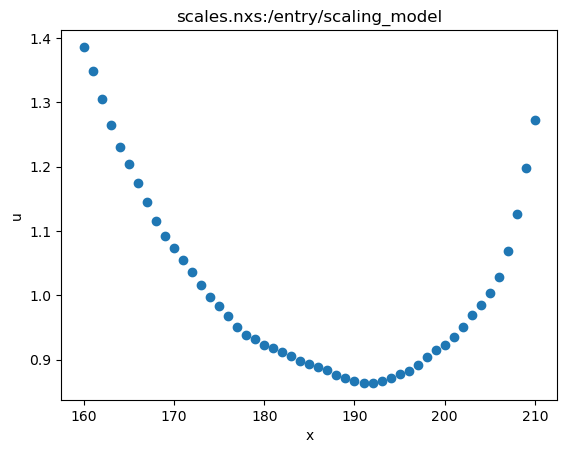

In [5]:
from nexusformat.nexus import nxload
scales = nxload('scales.nxs','r')['/entry/scaling_model']
scales.plot()

### Merging

After scaling, the equivalent observations can be merged. The following produces the file `merged.nxs` that includes a table of intensities and error estimates.

In [6]:
!mdx2.merge corrected.nxs --scale scales.nxs

Reading hkl_table from corrected.nxs
  importing as HKLTable from mdx2.data
Grouping redundant observations
Reading scaling_model from scales.nxs
  importing as ScalingModel from mdx2.scaling
Calculating scales
Merging
Exporting <class 'mdx2.data.HKLTable'> to nexus object
  writing hkl_table to merged.nxs
done!
